<a href="https://colab.research.google.com/github/renato-penna/fiap-hackaton-fase05/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi


Thu Jan 29 07:34:57 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.5 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
from ultralytics.utils.callbacks import add_integration_callbacks
from google.colab import drive
from pathlib import Path
import shutil
import os
import yaml
import glob
import time
import threading

# =========================================================
# 0. Mount Google Drive
# =========================================================
drive.mount('/content/drive')

DRIVE_ROOT = "/content/drive/MyDrive/colab"
PROJECT_NAME = "cloud-arch-security-mvp"

DRIVE_PROJECT = f"{DRIVE_ROOT}/{PROJECT_NAME}"
DRIVE_DATASET = f"{DRIVE_PROJECT}/dataset"
DRIVE_CHECKPOINTS = f"{DRIVE_PROJECT}/checkpoints"  # <-- NOVO: pasta de checkpoints

CONTENT_PROJECT = "/content/yolo-project"
CONTENT_DATASET = f"{CONTENT_PROJECT}/dataset"

# Cria pasta de checkpoints se não existir
os.makedirs(DRIVE_CHECKPOINTS, exist_ok=True)

# =========================================================
# 1. Preparar ambiente rápido (/content)
# =========================================================
if Path(CONTENT_PROJECT).exists():
    shutil.rmtree(CONTENT_PROJECT)

os.makedirs(CONTENT_PROJECT, exist_ok=True)

print("⏳ Copiando dataset para disco local (SSD)...")
shutil.copytree(DRIVE_DATASET, CONTENT_DATASET)
print("✅ Dataset copiado!")

%cd /content/yolo-project

# =========================================================
# 2. Analisar e Filtrar Classes (NOVO - CRÍTICO)
# =========================================================
print("\n📊 Analisando distribuição de classes...")

# Carrega o data.yaml original
with open("dataset/data.yaml", "r") as f:
    data_config = yaml.safe_load(f)

original_names = data_config['names']
print(f"Total de classes original: {len(original_names)}")

# Conta ocorrências de cada classe no train
from collections import Counter
class_counts = Counter()

train_labels_path = Path("dataset/train/labels")
for label_file in train_labels_path.glob("*.txt"):
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if parts:
                class_id = int(parts[0])
                class_counts[class_id] += 1

# Define threshold mínimo (classes com menos de 10 amostras serão agrupadas)
MIN_SAMPLES = 10
rare_classes = [cid for cid, count in class_counts.items() if count < MIN_SAMPLES]
print(f"⚠️ Classes com menos de {MIN_SAMPLES} amostras: {len(rare_classes)}")

# Lista as classes mais problemáticas
print("\n🔍 Top 20 classes com menos amostras:")
for cid, count in sorted(class_counts.items(), key=lambda x: x[1])[:20]:
    if cid < len(original_names):
        print(f"  ID {cid}: {original_names[cid]} - {count} amostras")

# =========================================================
# 3. Estratégia: Agrupar classes raras em categorias
# =========================================================
# Vamos criar um mapeamento simplificado focado em componentes de segurança
# Isso melhora a generalização do modelo

CATEGORY_MAPPING = {
    # Computação
    'compute': ['EC2', 'Lambda', 'EKS', 'Fargate', 'Container', 'Elastic Container Service',
                'Elastic Container Registry', 'ECS', 'App gateway', 'Server', 'Vm Scaleset'],

    # Bancos de Dados
    'database': ['RDS', 'DynamoDB', 'Aurora', 'DocumentDB', 'ElastiCache', 'Redis',
                 'Memcached', 'MySQL', 'PostgreSQL', 'Neptune', 'Redshift', 'Table',
                 'Oracle DB', 'Mongo DB', 'DB'],

    # Armazenamento
    'storage': ['S3', 'EBS', 'EFS', 'Glacier', 'Storage Gateway', 'File share',
                'Snowball', 'DataSync', 'Backup', 'Azure Storage - Files mobtmh'],

    # Rede
    'network': ['VPC Router', 'Internet Gateway', 'NAT Gateway', 'Transit Gateway',
                'Direct Connect', 'Private Link', 'V-net', 'Private Subnet',
                'Public Subnet', 'Availability Zone', 'Region', 'Endpoint',
                'Network Firewall', 'Network Adapter', 'Customer Gateway', 'VP Gateway'],

    # Segurança
    'security': ['IAM', 'IAM Role', 'Cognito', 'WAF', 'Firewall', 'Shield', 'GuardDuty',
                 'Inspector Agent', 'Security Hub', 'Secrets Manager', 'Key Management Service',
                 'CloudHSM', 'Certificate Manager', 'Macie', 'Detective', 'Key vault',
                 'Security Group', 'Firewall Manager', 'Config', 'Trusted Advisor'],

    # API e Gateway
    'api_gateway': ['API-Gateway', 'Appsync', 'ALB', 'ELB', 'Cloudfront', 'CDN',
                    'Route53', 'Cloud Map', 'Distribution', 'Edge Location'],

    # Mensageria e Eventos
    'messaging': ['SQS', 'SNS', 'EventBridge', 'Event Bus', 'MQ', 'Kinesis Data Streams',
                  'Step Function'],

    # Monitoramento
    'monitoring': ['Cloud Watch', 'CloudWatch Alarm', 'Cloud Trail', 'X-Ray',
                   'Azure monitor', 'Grafana', 'Prometheus', 'Flow logs'],

    # Identidade
    'identity': ['AAD', 'Active Directory Service', 'Sign-On', 'Users', 'Client'],

    # ML/AI
    'ml_ai': ['Sagemaker', 'Rekognition', 'Comprehend', 'Lex', 'Textract',
              'Transcribe', 'Translate', 'Machine Learning', 'Notebook'],

    # DevOps/CI-CD
    'devops': ['CodePipeline', 'CodeBuild', 'CodeCommit', 'CodeDeploy', 'Jenkins',
               'Github', 'Git', 'Docker Image', 'Image Builder', 'CloudFormation Stack',
               'Terraform', 'Deploy Stage', 'Build Environment'],

    # Serverless
    'serverless': ['Lambda', 'Fargate', 'Amplify', 'AppFlow'],

    # Grupos/Boundaries (importante para STRIDE)
    'groups': ['groups', 'Region', 'Availability Zone', 'VPC Router']
}

# Inverte o mapeamento para lookup rápido
name_to_category = {}
for category, names in CATEGORY_MAPPING.items():
    for name in names:
        name_to_category[name] = category

# Cria novo mapeamento de classes (categorias simplificadas)
SIMPLIFIED_NAMES = list(CATEGORY_MAPPING.keys()) + ['other']  # +1 para "other"
print(f"\n✅ Classes simplificadas: {len(SIMPLIFIED_NAMES)}")
print(f"   {SIMPLIFIED_NAMES}")

# =========================================================
# 4. Remapear labels para as novas categorias
# =========================================================
print("\n🔄 Remapeando labels para categorias simplificadas...")

def remap_label_file(label_path, original_names, name_to_category, simplified_names):
    """Remapeia um arquivo de labels para as novas categorias."""
    new_lines = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                old_class_id = int(parts[0])
                if old_class_id < len(original_names):
                    old_name = original_names[old_class_id]
                    # Encontra a categoria
                    category = name_to_category.get(old_name, 'other')
                    new_class_id = simplified_names.index(category)
                    # Reconstrói a linha com novo ID
                    new_line = f"{new_class_id} {' '.join(parts[1:])}\n"
                    new_lines.append(new_line)

    # Sobrescreve o arquivo
    with open(label_path, "w") as f:
        f.writelines(new_lines)

# Aplica remapeamento em todas as pastas
for split in ['train', 'valid', 'test']:
    labels_path = Path(f"dataset/{split}/labels")
    if labels_path.exists():
        for label_file in labels_path.glob("*.txt"):
            remap_label_file(label_file, original_names, name_to_category, SIMPLIFIED_NAMES)
        print(f"  ✅ {split}/labels remapeado")

# =========================================================
# 5. Atualizar data.yaml com novas classes
# =========================================================
new_data_config = {
    'train': '../train/images',
    'val': '../valid/images',
    'test': '../test/images',
    'nc': len(SIMPLIFIED_NAMES),
    'names': SIMPLIFIED_NAMES
}

with open("dataset/data.yaml", "w") as f:
    yaml.dump(new_data_config, f, default_flow_style=False)

print(f"\n✅ data.yaml atualizado com {len(SIMPLIFIED_NAMES)} categorias!")

# =========================================================
# 6. VERIFICAR SE HÁ CHECKPOINT PARA RETOMAR (NOVO!)
# =========================================================
print("\n🔍 Verificando checkpoints anteriores...")

checkpoint_files = sorted(glob.glob(f"{DRIVE_CHECKPOINTS}/epoch*.pt"))
last_checkpoint = None
resume_epoch = 0

if checkpoint_files:
    # Pega o checkpoint mais recente
    last_checkpoint = checkpoint_files[-1]
    # Extrai número da época do nome do arquivo (epoch_050.pt -> 50)
    try:
        resume_epoch = int(Path(last_checkpoint).stem.split('_')[1])
        print(f"✅ Checkpoint encontrado: {last_checkpoint}")
        print(f"   Retomando da época {resume_epoch}")
    except:
        last_checkpoint = None

# Também verifica se há um last.pt para retomar
if os.path.exists(f"{DRIVE_CHECKPOINTS}/last.pt"):
    last_checkpoint = f"{DRIVE_CHECKPOINTS}/last.pt"
    print(f"✅ Encontrado last.pt - será usado para retomar treinamento")

if not last_checkpoint:
    print("📭 Nenhum checkpoint encontrado - iniciando do zero")

# =========================================================
# 7. CALLBACK PARA SALVAR CHECKPOINTS NO DRIVE (NOVO!)
# =========================================================
SAVE_EVERY_N_EPOCHS = 5  # Salva a cada 5 épocas

def save_checkpoint_to_drive(trainer):
    """Callback que copia checkpoints para o Google Drive após cada época."""
    current_epoch = trainer.epoch + 1  # epoch é 0-indexed

    # Salva a cada N épocas
    if current_epoch % SAVE_EVERY_N_EPOCHS == 0:
        weights_dir = trainer.save_dir / "weights"

        # Copia last.pt (checkpoint mais recente)
        if (weights_dir / "last.pt").exists():
            # Salva com nome da época para histórico
            epoch_name = f"epoch_{current_epoch:03d}.pt"
            shutil.copy(
                weights_dir / "last.pt",
                f"{DRIVE_CHECKPOINTS}/{epoch_name}"
            )
            # Também mantém last.pt atualizado para retomada fácil
            shutil.copy(
                weights_dir / "last.pt",
                f"{DRIVE_CHECKPOINTS}/last.pt"
            )
            print(f"\n💾 Checkpoint salvo: {DRIVE_CHECKPOINTS}/{epoch_name}")

        # Copia best.pt se existir
        if (weights_dir / "best.pt").exists():
            shutil.copy(
                weights_dir / "best.pt",
                f"{DRIVE_CHECKPOINTS}/best.pt"
            )

# =========================================================
# 8. Carregar modelo (YOLOv8 Nano - ideal para Colab Free)
# =========================================================
# YOLOv8n é ideal para:
# - Colab free tier (treina 3x mais rápido que v11m)
# - Dataset de ícones (não precisa de modelo pesado)
# - Deploy leve no Streamlit (~6MB vs ~40MB)

if last_checkpoint:
    print(f"\n🔄 Carregando checkpoint: {last_checkpoint}")
    model = YOLO(last_checkpoint)
else:
    print("\n📦 Carregando modelo base: yolov8n.pt")
    model = YOLO("yolov8n.pt")

# Registra o callback de salvamento
model.add_callback("on_train_epoch_end", save_checkpoint_to_drive)

# =========================================================
# 9. Treinar com configuração OTIMIZADA para YOLOv8n
# =========================================================
print("\n🚀 Iniciando treinamento otimizado (YOLOv8n)...")
if last_checkpoint:
    print(f"   Retomando da época ~{resume_epoch}")

results = model.train(
    data="dataset/data.yaml",

    # TREINAMENTO PRINCIPAL (otimizado para modelo nano)
    epochs=150,           # Menos épocas (modelo menor converge mais rápido)
    patience=25,          # Early stopping
    batch=32,             # Batch maior (modelo nano usa menos VRAM)
    imgsz=640,            # Mantém 640

    # RETOMADA DE TREINAMENTO
    resume=True if last_checkpoint else False,  # Retoma se houver checkpoint

    # OTIMIZAÇÃO - CRÍTICO PARA DESBALANCEAMENTO
    optimizer='AdamW',    # AdamW é melhor para datasets pequenos/médios
    lr0=0.001,            # Learning rate inicial
    lrf=0.01,             # Learning rate final (decay)
    weight_decay=0.0005,  # Regularização L2
    warmup_epochs=5,      # Warmup para estabilizar início
    cos_lr=True,          # Cosine annealing LR (melhor convergência)

    # AUGMENTAÇÃO AGRESSIVA (compensa desbalanceamento)
    hsv_h=0.015,          # Variação de Hue
    hsv_s=0.7,            # Variação de Saturação
    hsv_v=0.4,            # Variação de Valor/Brilho
    degrees=15,           # Rotação ±15°
    translate=0.1,        # Translação 10%
    scale=0.5,            # Escala 50%
    shear=0.0,            # Sem cisalhamento (distorce ícones)
    perspective=0.0,      # Sem perspectiva
    flipud=0.0,           # Sem flip vertical (ícones têm orientação)
    fliplr=0.5,           # Flip horizontal 50%
    mosaic=1.0,           # Mosaic augmentation
    mixup=0.1,            # MixUp leve
    copy_paste=0.1,       # Copy-paste augmentation

    # LOSS E VALIDAÇÃO
    cls=1.0,              # Peso da loss de classificação
    box=7.5,              # Peso da loss de bounding box
    dfl=1.5,              # Distribution Focal Loss

    # INFRAESTRUTURA
    cache=True,           # Cache em RAM (muito mais rápido!)
    workers=4,            # Workers para dataloader
    device=0,             # GPU
    exist_ok=True,
    plots=True,
    save_period=5,        # Salva checkpoint a cada 5 épocas

    # NOME DO EXPERIMENTO
    name='train_mvp_optimized',
    project='runs/detect',
)

# =========================================================
# 10. Salvar resultados FINAIS no Drive
# =========================================================
DEST_WEIGHTS = f"{DRIVE_PROJECT}/weights_backup"
SOURCE_WEIGHTS = "runs/detect/train_mvp_optimized/weights"

os.makedirs(DEST_WEIGHTS, exist_ok=True)

print("\n💾 Salvando modelo treinado no Google Drive...")

if os.path.exists(f"{SOURCE_WEIGHTS}/best.pt"):
    shutil.copy(f"{SOURCE_WEIGHTS}/best.pt", f"{DEST_WEIGHTS}/best_optimized.pt")
    shutil.copy(f"{SOURCE_WEIGHTS}/last.pt", f"{DEST_WEIGHTS}/last_optimized.pt")

    # Também copia para a pasta de checkpoints (versão final)
    shutil.copy(f"{SOURCE_WEIGHTS}/best.pt", f"{DRIVE_CHECKPOINTS}/best_final.pt")

    # Salva também o mapeamento de classes para usar no app
    with open(f"{DEST_WEIGHTS}/class_mapping.yaml", "w") as f:
        yaml.dump({
            'simplified_names': SIMPLIFIED_NAMES,
            'category_mapping': CATEGORY_MAPPING
        }, f)

    print(f"✅ SUCESSO! Modelo salvo em: {DEST_WEIGHTS}/best_optimized.pt")
    print(f"✅ Mapeamento de classes salvo em: {DEST_WEIGHTS}/class_mapping.yaml")
    print(f"✅ Checkpoints disponíveis em: {DRIVE_CHECKPOINTS}/")
else:
    print("⚠️ Arquivo best.pt não encontrado - verificar logs de treinamento")

# Copia logs e métricas
if os.path.exists("runs/detect/train_mvp_optimized"):
    shutil.copytree(
        "runs/detect/train_mvp_optimized",
        f"{DRIVE_PROJECT}/runs_optimized",
        dirs_exist_ok=True
    )
    print(f"✅ Logs salvos em: {DRIVE_PROJECT}/runs_optimized")

# =========================================================
# 11. Limpar checkpoints antigos (opcional - mantém últimos 3)
# =========================================================
print("\n🧹 Limpando checkpoints antigos (mantendo últimos 3)...")
checkpoint_files = sorted(glob.glob(f"{DRIVE_CHECKPOINTS}/epoch*.pt"))
if len(checkpoint_files) > 3:
    for old_ckpt in checkpoint_files[:-3]:
        os.remove(old_ckpt)
        print(f"   Removido: {Path(old_ckpt).name}")
print("✅ Limpeza concluída!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⏳ Copiando dataset para disco local (SSD)...
✅ Dataset copiado!
/content/yolo-project

📊 Analisando distribuição de classes...
Total de classes original: 203
⚠️ Classes com menos de 10 amostras: 111

🔍 Top 20 classes com menos amostras:
  ID 47: CodeDeploy - 1 amostras
  ID 163: Security Hub - 1 amostras
  ID 42: CloudHSM - 1 amostras
  ID 141: Prometheus - 1 amostras
  ID 101: Grafana - 1 amostras
  ID 143: Quarkus - 1 amostras
  ID 130: Network Adapter - 1 amostras
  ID 127: MySQL - 1 amostras
  ID 187: Twilio - 1 amostras
  ID 115: Kibana - 1 amostras

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive

🔍 Procurando modelo treinado...
✅ Modelo encontrado: /content/drive/MyDrive/colab/cloud-arch-security-mvp/checkpoints/best.pt
📊 Modelo tem 14 classes

⏳ Copiando dataset do Drive para disco local...
✅ Dataset copiado!
📊 Dataset tem 203 classes

⚠️ INCOMPATIBILIDADE DETECTADA!
   Modelo: 14 classes
   Dataset: 203 classes

💡 O modelo foi treinado com classes diferentes do dataset atual.
   Isso acontece quando você treinou ANTES de aplicar o remapeamento.

🔧 SOLUÇÕES:
   1. Delete os checkpoints antigos e retreine com as novas classes
   2. Ou valide apenas visualmente (pulando métricas)

🖼️ Testando em imagem de exemplo...
   Imagem: download-4-_jpg.rf.f

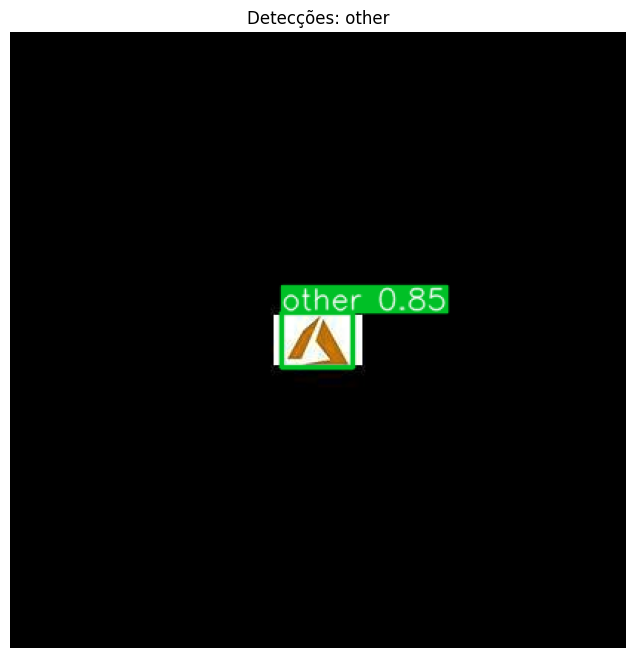

In [3]:
# =========================================================
# 12. VALIDAÇÃO DO MODELO TREINADO (opcional)
# =========================================================
# Execute esta célula APÓS o treinamento para validar o modelo
# Funciona mesmo se a sessão reiniciou (busca do Google Drive)

from ultralytics import YOLO
import matplotlib.pyplot as plt
import random
from pathlib import Path
import os
import shutil

# Configuração (precisa redefinir se sessão reiniciou)
DRIVE_ROOT = "/content/drive/MyDrive/colab"
PROJECT_NAME = "cloud-arch-security-mvp"
DRIVE_PROJECT = f"{DRIVE_ROOT}/{PROJECT_NAME}"
DRIVE_CHECKPOINTS = f"{DRIVE_PROJECT}/checkpoints"
DRIVE_DATASET = f"{DRIVE_PROJECT}/dataset"

# Monta o Drive se ainda não estiver montado
from google.colab import drive
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')

# =========================================================
# Encontrar o melhor modelo (local ou no Drive)
# =========================================================
print("\n🔍 Procurando modelo treinado...")

# Lista de possíveis localizações do modelo
model_paths = [
    "runs/detect/train_mvp_optimized/weights/best.pt",  # Local (se treino acabou de terminar)
    f"{DRIVE_CHECKPOINTS}/best.pt",                      # Checkpoint no Drive
    f"{DRIVE_CHECKPOINTS}/best_final.pt",                # Versão final no Drive
    f"{DRIVE_PROJECT}/weights_backup/best_optimized.pt", # Backup no Drive
]

best_model_path = None
for path in model_paths:
    if os.path.exists(path):
        best_model_path = path
        print(f"✅ Modelo encontrado: {path}")
        break

if not best_model_path:
    print("❌ Nenhum modelo encontrado!")
    print("   Verifique se o treinamento foi concluído e os arquivos salvos no Drive.")
    print(f"   Pasta esperada: {DRIVE_CHECKPOINTS}/")
else:
    # Carrega o modelo
    val_model = YOLO(best_model_path)

    # Verifica quantas classes o modelo tem
    num_model_classes = len(val_model.names)
    print(f"📊 Modelo tem {num_model_classes} classes")

    # =========================================================
    # Preparar dataset de teste (se não existe localmente)
    # =========================================================
    CONTENT_DATASET = "/content/yolo-project/dataset"

    if not os.path.exists(CONTENT_DATASET):
        print("\n⏳ Copiando dataset do Drive para disco local...")
        os.makedirs("/content/yolo-project", exist_ok=True)
        shutil.copytree(DRIVE_DATASET, CONTENT_DATASET)
        print("✅ Dataset copiado!")

    # =========================================================
    # Verificar compatibilidade de classes
    # =========================================================
    import yaml

    with open(f"{CONTENT_DATASET}/data.yaml", "r") as f:
        data_config = yaml.safe_load(f)

    num_dataset_classes = data_config.get('nc', len(data_config.get('names', [])))
    print(f"📊 Dataset tem {num_dataset_classes} classes")

    if num_model_classes != num_dataset_classes:
        print(f"\n⚠️ INCOMPATIBILIDADE DETECTADA!")
        print(f"   Modelo: {num_model_classes} classes")
        print(f"   Dataset: {num_dataset_classes} classes")
        print(f"\n💡 O modelo foi treinado com classes diferentes do dataset atual.")
        print(f"   Isso acontece quando você treinou ANTES de aplicar o remapeamento.")
        print(f"\n🔧 SOLUÇÕES:")
        print(f"   1. Delete os checkpoints antigos e retreine com as novas classes")
        print(f"   2. Ou valide apenas visualmente (pulando métricas)")

        # Pula validação formal, faz apenas teste visual
        skip_validation = True
    else:
        skip_validation = False

    # =========================================================
    # Validação no conjunto de teste (se compatível)
    # =========================================================
    if not skip_validation:
        print("\n🧪 Validando modelo treinado...")

        val_results = val_model.val(
            data=f"{CONTENT_DATASET}/data.yaml",
            split="test",
            plots=True,
            save_json=True
        )

        print("\n📊 MÉTRICAS DE VALIDAÇÃO:")
        print(f"   mAP50: {val_results.box.map50:.4f}")
        print(f"   mAP50-95: {val_results.box.map:.4f}")
        print(f"   Precisão: {val_results.box.mp:.4f}")
        print(f"   Recall: {val_results.box.mr:.4f}")

        # Mostra métricas por classe
        print("\n📈 mAP50 por categoria:")
        for i, name in enumerate(val_model.names.values()):
            if i < len(val_results.box.ap50):
                ap = val_results.box.ap50[i]
                print(f"   {name}: {ap:.4f}")

    # =========================================================
    # 13. TESTE EM IMAGEM DE EXEMPLO (sempre funciona)
    # =========================================================
    print("\n🖼️ Testando em imagem de exemplo...")

    test_images = list(Path(f"{CONTENT_DATASET}/test/images").glob("*.jpg")) + \
                  list(Path(f"{CONTENT_DATASET}/test/images").glob("*.png"))

    # Também tenta do Drive diretamente
    if not test_images:
        test_images = list(Path(f"{DRIVE_DATASET}/test/images").glob("*.jpg")) + \
                      list(Path(f"{DRIVE_DATASET}/test/images").glob("*.png"))

    if test_images:
        # Seleciona imagem aleatória
        test_img = random.choice(test_images)
        print(f"   Imagem: {test_img.name}")

        # Executa inferência
        test_results = val_model(str(test_img), conf=0.35, verbose=False)

        # Mostra detecções
        detected_classes = set()
        for r in test_results:
            for box in r.boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                cls_name = val_model.names[cls_id]
                detected_classes.add(cls_name)
                print(f"   Detectado: {cls_name} (conf: {conf:.2f})")

        if not detected_classes:
            print("   ⚠️ Nenhum componente detectado. Tente outra imagem ou ajuste a confiança.")

        # Salva imagem com detecções
        result_img = test_results[0].plot()
        result_path = f"{DRIVE_PROJECT}/test_detection.jpg"

        from PIL import Image
        import numpy as np
        img_pil = Image.fromarray(result_img)
        img_pil.save(result_path)
        print(f"\n✅ Imagem de teste salva em: {result_path}")

        # Exibe no notebook
        plt.figure(figsize=(12, 8))
        plt.imshow(result_img)
        plt.axis('off')
        plt.title(f"Detecções: {', '.join(detected_classes) if detected_classes else 'Nenhuma'}")
        plt.show()
    else:
        print("   ⚠️ Nenhuma imagem de teste encontrada no dataset")